In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import blimpy as bl 
import glob
%matplotlib inline

In [2]:
dat = '/datax/scratch/benjb/bliss_voyager_test/injections/synthetic_data_10_injections.0000.dat'
h5 = '/datax/scratch/benjb/bliss_voyager_test/injections/synthetic_data_10_injections.0000.h5'

df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)

ff = df['freq_start'].values

In [3]:
ff = np.sort(ff)
print(ff)

[10000.009997 10000.029999 10000.049998 10000.069997 10000.088753
 10000.088859 10000.089119 10000.089996 10000.109993 10000.129995
 10000.130042 10000.149994 10000.150036 10000.150044 10000.15029
 10000.15038  10000.150416 10000.150458 10000.150528 10000.150589
 10000.15083  10000.15088  10000.150992 10000.151028 10000.169993
 10000.189993]


In [6]:
bw = 0.002
mins = []
maxes = []
for f in ff:
    fb = bl.Waterfall(h5, f_start=f-bw/2, f_stop=f+bw/2)
    data = np.squeeze(fb.data)
    mins.append(np.min(data))
    maxes.append(np.max(data))
print(np.min(mins))
print(np.max(maxes))

6257530000.0
68439142000.0


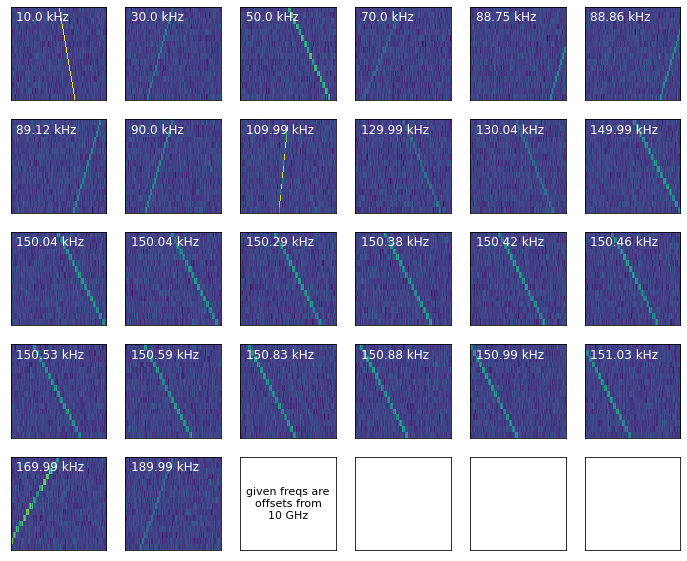

In [7]:
fig, axs = plt.subplots(5, 6, figsize=(12, 10))
# bw = 0.001
for i in range(5):
    for j in range(6):
        k = 6*i+j
        if k < 26:
            f = ff[k]
            fb = bl.Waterfall(h5, f_start=f-bw/2, f_stop=f+bw/2)
            data = np.squeeze(fb.data)
            axs[i][j].imshow(np.log10(data), interpolation='None', aspect='auto', vmin=np.log10(np.min(mins)), vmax=np.log10(np.max(maxes)))
            axs[i][j].text(0.06, 0.85, f'{round((f-10000)*1000, 2)} kHz', size=12, color='white', horizontalalignment='left', transform=axs[i][j].transAxes)
        elif k == 26:
            axs[i][j].text(0.5, 0.5, f'given freqs are\noffsets from\n10 GHz', size=11, color='black', horizontalalignment='center', verticalalignment='center', transform=axs[i][j].transAxes)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
plt.savefig('/datax/scratch/benjb/bliss_voyager_test/injections/hit_plot.pdf', bbox_inches='tight')
plt.show()

1
2
3
4
5
6
7
8
9
(31, 9)


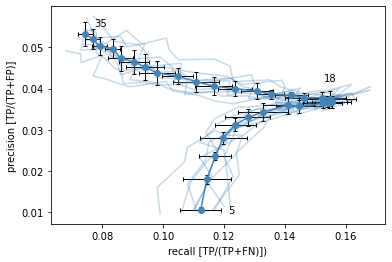

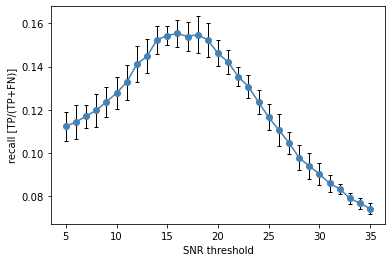

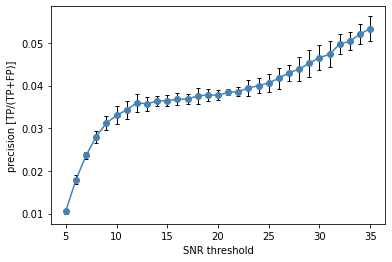

In [ ]:
sp_arr = []
sr_arr = []

for n in range(9):
    m = n+1
    dats = glob.glob(f'/datax/scratch/benjb/bliss_voyager_test/injections/synthetic_data_2000_injections_{m}*.dat')
    print(m)

    snrs = []
    fps = []
    tps = []
    fns = []
    precisions = []
    recalls = []

    for k in range(len(dats)):

        dat = dats[k]

        snr = float(dat[89:-4])
        #print(snr)
        snrs.append(snr)

        df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                                    'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                                    'Full_number_of_hits'], skiprows=9)
        ff = df['freq_start'].values
        n_inj = 1000
        fillspace = 10000
        pfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + fillspace/1e6 + 10000
        nfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + 3*fillspace/1e6 + 10000
        #print(pfreqs[:10])
        #print(nfreqs[:10])

        fp = 0
        tp = 0
        tn = 0
        fn = 0

        for i in range(n_inj):
            pf = pfreqs[i]
            nf = nfreqs[i]
            pdiffvec = ff - pf
            ndiffvec = ff - nf
            if np.min(np.abs(pdiffvec))*1000 < 0.1: # permit accuracy to within 0.1 kHz
                tp += 1
            else:
                fn += 1
            if np.min(np.abs(ndiffvec))*1000 > 10: # whole block must be clear
                tn += 1
        fp = len(ff)-tp

        #print(f'TP: {tp}')
        #print(f'FP: {fp}')
        #print(f'FN: {fn}')

        #print(f'precision: {tp/(tp+fp)}')
        #print(f'recall: {tp/(tp+fn)}')
        precisions.append(tp/(tp+fp))
        recalls.append(tp/(tp+fn))
    
    snrs = np.array(snrs)
    precisions = np.array(precisions)
    recalls = np.array(recalls)

    sp = precisions[np.argsort(snrs)]
    sr = recalls[np.argsort(snrs)]
    sp_arr.append(sp)
    sr_arr.append(sr)
    plt.plot(sr, sp, color='steelblue', alpha=0.3)

sp_arr = np.transpose(sp_arr)
sr_arr = np.transpose(sr_arr)
print(np.shape(sp_arr))

sp_avgvec = [] # y-positions of points for average PR curve
sr_avgvec = [] # x-positions '''
sp_errvec = [] # y-errors '''
sr_errvec = [] # x-errors '''
distvec = [] # distances of points from (1, 1)

for i in range(len(sp_arr)):

    sp_bit = sp_arr[i]
    sr_bit = sr_arr[i]
    
    sp_avg = np.mean(sp_bit)
    sr_avg = np.mean(sr_bit)
    sp_err = np.std(sp_bit)
    sr_err = np.std(sr_bit)

    sp_avgvec.append(sp_avg)
    sr_avgvec.append(sr_avg)
    sp_errvec.append(sp_err)
    sr_errvec.append(sr_err)

    distance = np.sqrt((1-sp_avg)**2 + (1-sr_avg)**2)
    distvec.append(distance)

plt.errorbar(x=sr_avgvec, y=sp_avgvec, yerr=sp_errvec, xerr=sr_errvec, marker='o', color='steelblue',
             ecolor='k', capsize=2, elinewidth=1)
plt.xlabel('recall [TP/(TP+FN)])')
plt.ylabel('precision [TP/(TP+FP)]')

best_snr = np.argmin(distvec) + 5
plt.text(sr_avgvec[np.argmin(distvec)], sp_avgvec[np.argmin(distvec)]+0.005, str(best_snr), ha='center', va='center')
plt.text(sr_avgvec[0]+0.01, sp_avgvec[0], 5, ha='center', va='center')
plt.text(sr_avgvec[-1]+0.005, sp_avgvec[-1]+0.0025, 35, ha='center', va='center')
#plt.xlim(0,1)
#plt.ylim(0,1)
#plt.savefig('/datax/scratch/benjb/bliss_voyager_test/injections/bliss_PR_curve_9_realizations_SNRs_10_1000.pdf', bbox_inches='tight')
plt.show()

plt.errorbar(np.sort(snrs), sr_avgvec, sr_errvec, c='steelblue', marker='o', ecolor='k', capsize=2, elinewidth=1, label='recall')
plt.errorbar(np.sort(snrs), sp_avgvec, sp_errvec, c='firebrick', marker='o', ecolor='k', capsize=2, elinewidth=1, label='precision')
plt.xlabel('SNR threshold')
plt.ylabel('fraction (precision or recall)')
plt.show()

0
1
2
(40, 3)


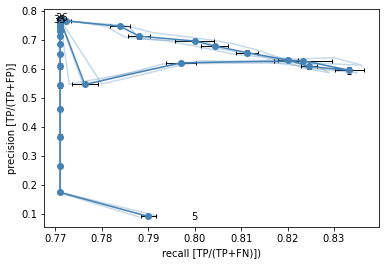

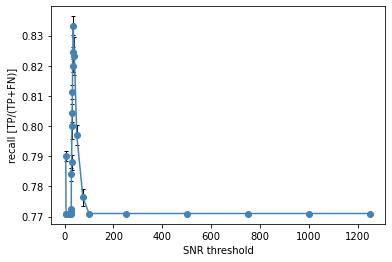

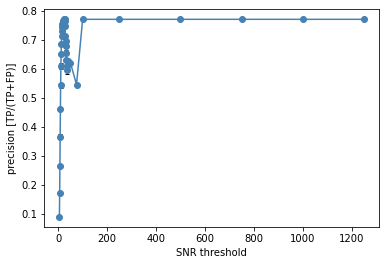

In [6]:
sp_arr = []
sr_arr = []

for n in range(3):
    m = n
    dats = glob.glob(f'/datax/scratch/benjb/bliss_voyager_test/injections/high_SNR_no_drift_injections/synthetic_data_2000_injections_{m}*.dat')
    #dats = glob.glob(f'/datax/scratch/benjb/bliss_voyager_test/injections/high_SNR_injections/synthetic_data_2000_injections_{m}*.dat')
    print(m)

    snrs = []
    fps = []
    tps = []
    fns = []
    precisions = []
    recalls = []

    for k in range(len(dats)):

        dat = dats[k]

        snr = float(dat[118:-4])
        #print(snr)
        snrs.append(snr)

        df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                                    'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                                    'Full_number_of_hits'], skiprows=9)
        ff = df['freq_start'].values
        n_inj = 1000
        fillspace = 10000
        pfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + fillspace/1e6 + 10000
        nfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + 3*fillspace/1e6 + 10000
        #print(pfreqs[:10])
        #print(nfreqs[:10])

        fp = 0
        tp = 0
        tn = 0
        fn = 0

        for i in range(n_inj):
            pf = pfreqs[i]
            nf = nfreqs[i]
            pdiffvec = ff - pf
            ndiffvec = ff - nf
            if np.min(np.abs(pdiffvec))*1000 < 1.2: # permit accuracy to within 1.2 kHz
                tp += 1
            else:
                fn += 1
            if np.min(np.abs(ndiffvec))*1000 > 10: # whole block must be clear
                tn += 1
        fp = len(ff)-tp

        #print(f'TP: {tp}')
        #print(f'FP: {fp}')
        #print(f'FN: {fn}')

        #print(f'precision: {tp/(tp+fp)}')
        #print(f'recall: {tp/(tp+fn)}')
        precisions.append(tp/(tp+fp))
        recalls.append(tp/(tp+fn))
    
    snrs = np.array(snrs)
    precisions = np.array(precisions)
    recalls = np.array(recalls)

    sp = precisions[np.argsort(snrs)]
    sr = recalls[np.argsort(snrs)]
    sp_arr.append(sp)
    sr_arr.append(sr)
    plt.plot(sr, sp, color='steelblue', alpha=0.3)

sp_arr = np.transpose(sp_arr)
sr_arr = np.transpose(sr_arr)
print(np.shape(sp_arr))

sp_avgvec = [] # y-positions of points for average PR curve
sr_avgvec = [] # x-positions '''
sp_errvec = [] # y-errors '''
sr_errvec = [] # x-errors '''
distvec = [] # distances of points from (1, 1)

for i in range(len(sp_arr)):

    sp_bit = sp_arr[i]
    sr_bit = sr_arr[i]
    
    sp_avg = np.mean(sp_bit)
    sr_avg = np.mean(sr_bit)
    sp_err = np.std(sp_bit)
    sr_err = np.std(sr_bit)

    sp_avgvec.append(sp_avg)
    sr_avgvec.append(sr_avg)
    sp_errvec.append(sp_err)
    sr_errvec.append(sr_err)

    distance = np.sqrt((1-sp_avg)**2 + (1-sr_avg)**2)
    distvec.append(distance)

plt.errorbar(x=sr_avgvec, y=sp_avgvec, yerr=sp_errvec, xerr=sr_errvec, marker='o', color='steelblue',
             ecolor='k', capsize=2, elinewidth=1)
plt.xlabel('recall [TP/(TP+FN)])')
plt.ylabel('precision [TP/(TP+FP)]')

best_snr = np.argmin(distvec) + 5
plt.text(sr_avgvec[np.argmin(distvec)], sp_avgvec[np.argmin(distvec)]+0.005, str(best_snr), ha='center', va='center')
plt.text(sr_avgvec[0]+0.01, sp_avgvec[0], 5, ha='center', va='center')
plt.text(sr_avgvec[-1], sp_avgvec[-1]-0.003, 35, ha='center', va='center')
#plt.xlim(0,1)
#plt.ylim(0,1)
#plt.savefig('/datax/scratch/benjb/bliss_voyager_test/injections/bliss_PR_curve_10_realizations_SNRs_1000_drift_0.1.pdf', bbox_inches='tight')
plt.show()

plt.errorbar(np.sort(snrs), sr_avgvec, sr_errvec, c='steelblue', marker='o', ecolor='k', capsize=2, elinewidth=1)
plt.xlabel('SNR threshold')
plt.ylabel('recall [TP/(TP+FN)]')
plt.show()

plt.errorbar(np.sort(snrs), sp_avgvec, sp_errvec, c='steelblue', marker='o', ecolor='k', capsize=2, elinewidth=1)
plt.xlabel('SNR threshold')
plt.ylabel('precision [TP/(TP+FP)]')
plt.show()

In [2]:
a = '/datax/scratch/benjb/bliss_voyager_test/injections/l1_testing/synthetic_data_2000_injections_1.0000_L1_7.dat'
print(a[103:-4])

7


1
7.0
1.5684234115605595
8.0
1.5745552378878027
9.0
1.5766202261859623
10.0
1.5766202261859623
11.0
1.581837790277946
12.0
1.5870974375975997
13.0
1.5914317632810508
14.0
1.5935744886868337
16.0
1.6010830909222937
18.0
1.6076139466952346
20.0
1.6130802146697651
25.0
1.62414154562798
30.0
1.6413064052213833
35.0
1.6589439195565288
2.0
1.5568024091542056
3.0
1.5613231703025674
4.0
1.5643492056580226
5.0
1.5653712359667575
6.0
1.56638857008694
40.0
1.667357901730133
50.0
1.6997300131439528
60.0
1.7206814251663274
75.0
1.7618332218577835
100.0
1.834650640440018
125.0
1.9435566369877306
150.0
2.1019940224946447
175.0
2.246423508047844
2
7.0
1.553345840941097
8.0
1.5553507890161609
9.0
1.5553507890161609
10.0
1.5553507890161609
11.0
1.5584086076882164
12.0
1.5624920020440012
13.0
1.563532950382474
14.0
1.5655919218213625
16.0
1.568690549840315
18.0
1.574992628765165
20.0
1.5802604925864863
25.0
1.5919198183198369
30.0
1.5995696833881972
35.0
1.6095496649448584
2.0
1.5347860442966768
3.0
1.54

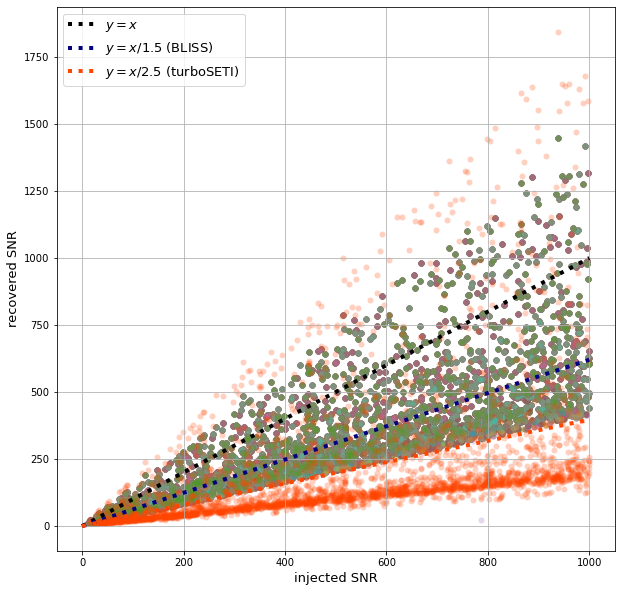

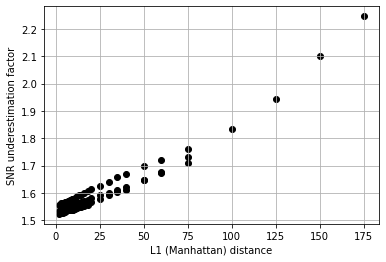

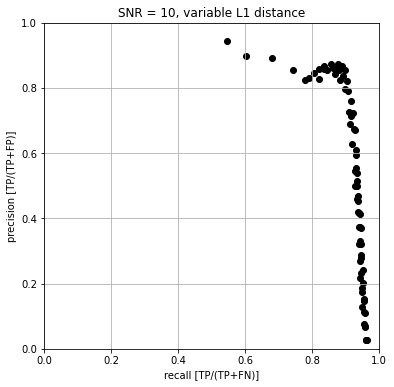

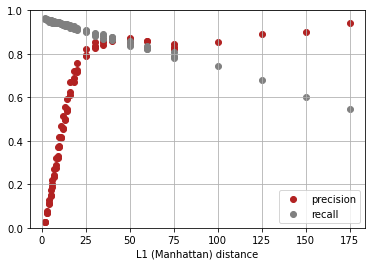

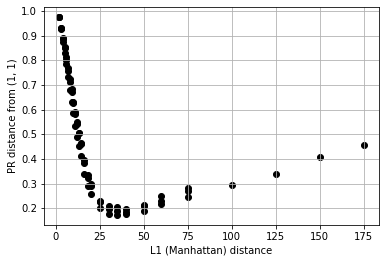

In [2]:
# Full plot

fig = plt.figure(figsize=(10, 10))

bliss_average_factor_vec = []
l1_vec = []
precision_vec = []
recall_vec = []

for n in range(3):
    m = n+1
    dats = glob.glob(f'/datax/scratch/benjb/bliss_voyager_test/injections/l1_testing/synthetic_data_2000_injections_{m}*.dat')
    print(m)

    snrs = []
    fps = []
    tps = []
    fns = []
    precisions = []
    recalls = []

    a = np.load(f'/datax/scratch/benjb/bliss_voyager_test/injections/synthetic_data_2000_injection_parameters_{m}.npy')
    drifts = a[1]
    snrvec = a[2]

    for k in range(len(dats)):

        recorded_snrvec = []

        dat = dats[k]

        #snr = float(dat[89:-4])
        snr = 10 # hard-set SNR for this plot
        l1 = float(dat[103:-4])
        print(l1)
        #print(snr)
        snrs.append(snr)

        df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                                    'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                                    'Full_number_of_hits'], skiprows=9)
        ff = df['freq_start'].values
        dd = df['Drift_Rate'].values
        ss = df['SNR'].values
        n_inj = 1000
        fillspace = 10000
        pfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + fillspace/1e6 + 10000

        tp = 0

        for i in range(n_inj):
            pf = pfreqs[i]
            pdiffvec = ff - pf
            d = drifts[2*i]
            best_candidate_idxs = np.where(np.abs(pdiffvec)*1000 < 2)[0]
            #print('SNR', str(snr), 'best idx', str(best_candidate_idxs))
            best_candidate_drifts = np.concatenate((dd[best_candidate_idxs], [100])) # add 100 as a fix for len-0 case
            if (np.min(np.abs(pdiffvec))*1000 < 2) & (np.min(np.abs(best_candidate_drifts-d)) < 0.5): # permit accuracy to within 2 kHz
                #print(best_candidate_drifts)
                true_idx = best_candidate_idxs[np.argmin(np.abs(best_candidate_drifts-d))]
                recorded_snr = ss[true_idx]
                tp += 1
                #print('recorded SNR', str(recorded_snr))
                #print(true_idx, snrvec[2*i], recorded_snr)
                recorded_snrvec.append(recorded_snr)
            else:
                recorded_snrvec.append(np.nan)

        plt.scatter(snrvec[::2], recorded_snrvec, 
                    #color='navy',
                    alpha=0.25, lw=0, marker='o')
        bliss_average_factor = 1/np.average(np.nan_to_num(np.array(recorded_snrvec))/snrvec[::2])
        print(bliss_average_factor)
        #plt.plot([0,1000],[0,1000/np.average(bliss_average_factor)], lw=4, ls=':')
        #print(1/np.average(np.nan_to_num(np.array(recorded_snrvec))/snrvec[::2]))
        l1_vec.append(l1)
        bliss_average_factor_vec.append(bliss_average_factor)
        precision_vec.append(tp / len(ff))
        recall_vec.append(tp / n_inj)
        #break

print(f'BLISS factor {np.average(bliss_average_factor_vec)}')


turboseti_snr_list = [5,8,10,15,20,25,30,35,40,50,75,100,250,500,750,1000,1250]


turboseti_average_factor_vec = []

for n in range(3):
    m = n+1
    snrs = []
    fps = []
    tps = []
    fns = []
    precisions = []
    recalls = []

    a = np.load(f'/datax/scratch/benjb/bliss_voyager_test/injections/synthetic_data_2000_injection_parameters_{m}.npy')
    drifts = a[1]
    snrvec = a[2]
    
    for snr in turboseti_snr_list:
        snr = 10
        m = n+1

        recorded_snrvec = []

        dats = glob.glob(f'/datax/scratch/benjb/bliss_voyager_test/injections/seticore/{snr}/synthetic_data_2000_injections_{m}*.dat')

        dat = dats[0]

        snrs.append(snr)

        df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                                    'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                                    'Full_number_of_hits'], skiprows=9)
        ff = df['Uncorrected_Frequency'].values
        dd = df['Drift_Rate'].values
        ss = df['SNR'].values
        n_inj = 1000
        fillspace = 10000
        pfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + fillspace/1e6 + 10000

        for i in range(n_inj):
            pf = pfreqs[i]
            pdiffvec = ff - pf
            d = drifts[2*i]
            best_candidate_idxs = np.where(np.abs(pdiffvec)*1000 < 2)[0]
            #print('SNR', str(snr), 'best idx', str(best_candidate_idxs))
            best_candidate_drifts = np.concatenate((dd[best_candidate_idxs], [100])) # add 100 as a fix for len-0 case
            if (np.min(np.abs(pdiffvec))*1000 < 2) & (np.min(np.abs(best_candidate_drifts-d)) < 0.5): # permit accuracy to within 2 kHz
                #print(best_candidate_drifts)
                true_idx = best_candidate_idxs[np.argmin(np.abs(best_candidate_drifts-d))]
                recorded_snr = ss[true_idx]
                #print('recorded SNR', str(recorded_snr))
                #print(true_idx, snrvec[2*i], recorded_snr)
                recorded_snrvec.append(recorded_snr)
            else:
                recorded_snrvec.append(np.nan)
            #break

        #plt.plot(sr, sp, color='orangered', alpha=0.1)
        #print(snrvec[::2][:10])
        #print(recorded_snrvec[:10])
        plt.scatter(snrvec[::2], recorded_snrvec, color='orangered', alpha=0.25, lw=0, marker='o')
        #print(1/np.average(np.nan_to_num(np.array(recorded_snrvec))/snrvec[::2]))
        turboseti_average_factor_vec.append(1/np.average(np.nan_to_num(np.array(recorded_snrvec))/snrvec[::2]))
        break

print(f'turboSETI factor {np.average(turboseti_average_factor_vec)}')

plt.plot([0,1000],[0,1000], c='k', lw=4, ls=':', label=r'$y = x$')
plt.plot([0,1000],[0,1000/np.average(bliss_average_factor_vec)], c='navy', lw=4, ls=':', label=r'$y = x/1.5$ (BLISS)')
plt.plot([0,1000],[0,1000/np.average(turboseti_average_factor_vec)], c='orangered', lw=4, ls=':', label=r'$y = x/2.5$ (turboSETI)')

#plt.errorbar(x=sr_avgvec, y=sp_avgvec, yerr=sp_errvec, xerr=sr_errvec, marker='o', color='orangered',
#             ecolor='k', capsize=2, elinewidth=1, label='turboSETI: variable SNR, variable drift')

plt.xlabel('injected SNR', size=13)
plt.ylabel('recovered SNR', size=13)

plt.legend(loc='upper left', fontsize=13)
plt.grid(which='major')

#plt.xlim(0,1)
#plt.ylim(0,1)
plt.savefig('/datax/scratch/benjb/bliss_voyager_test/injections/bliss_turboSETI_L1_effect.pdf', bbox_inches='tight')
plt.show()

plt.scatter(l1_vec, bliss_average_factor_vec, c='k')
plt.grid()
plt.xlabel('L1 (Manhattan) distance')
plt.ylabel('SNR underestimation factor')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6,6))
plt.scatter(recall_vec, precision_vec, c='k')
plt.grid()
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('recall [TP/(TP+FN)]')
plt.ylabel('precision [TP/(TP+FP)]')
plt.title('SNR = 10, variable L1 distance')
plt.show()

plt.scatter(l1_vec, precision_vec, c='firebrick', label='precision')
plt.scatter(l1_vec, recall_vec, c='grey', label='recall')
plt.xlabel('L1 (Manhattan) distance')
plt.grid()
plt.ylim(0,1)
plt.legend()
plt.show()

precision_vec = np.array(precision_vec)
recall_vec = np.array(recall_vec)
dvec = np.sqrt((1-precision_vec)**2 + (1-recall_vec)**2)

plt.scatter(l1_vec, dvec, c='k')
plt.xlabel('L1 (Manhattan) distance')
plt.ylabel('PR distance from (1, 1)')
plt.grid()
plt.show()


In [13]:
for i in range(20):
    print(l1_vec[i], precision_vec[i])

7.0 0.24260204081632653
8.0 0.2878464818763326
9.0 0.32972027972027973
10.0 0.3740579135263784
11.0 0.41875
12.0 0.46074074074074073
13.0 0.4978563772775991
14.0 0.5465801886792453
16.0 0.6267029972752044
18.0 0.6882530120481928
20.0 0.7254588986432562
25.0 0.7962798937112489
30.0 0.8246268656716418
35.0 0.8420542635658915
2.0 0.026047442590138217
3.0 0.07023975364762812
4.0 0.11219454887218046
5.0 0.15249360613810742
6.0 0.20025215381382644
7.0 0.2682996297351182


In [36]:
a = np.load('/datax/scratch/benjb/bliss_voyager_test/injections/synthetic_data_2000_injection_parameters_1.npy')
print(a[1][:10])
print(a[2][:10])
print(len(a[2]))

[ 3.809186    2.79952598  2.56390239 -0.07024892 -0.70394575  2.79657385
  3.83703156 -2.81353625 -2.52706141 -1.52179761]
[248.08825007 411.73751874 136.85445244 301.42011598 644.17355844
 791.26399026 324.26313184 116.72184028 915.40314022 149.84948412]
2000


0
1
2
(47, 3)
0
[ 2.1225392   1.29978325  1.65274617 ... -3.38556048  2.46421917
 -3.17518549]
1
2
3
4
5
6
7
8
9
(40, 10)
1
2
3
4
5
6
7
8
9
(40, 9)
(19, 3)
(19, 3)
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000
len pfreqs =  1000
len drifts =  2000


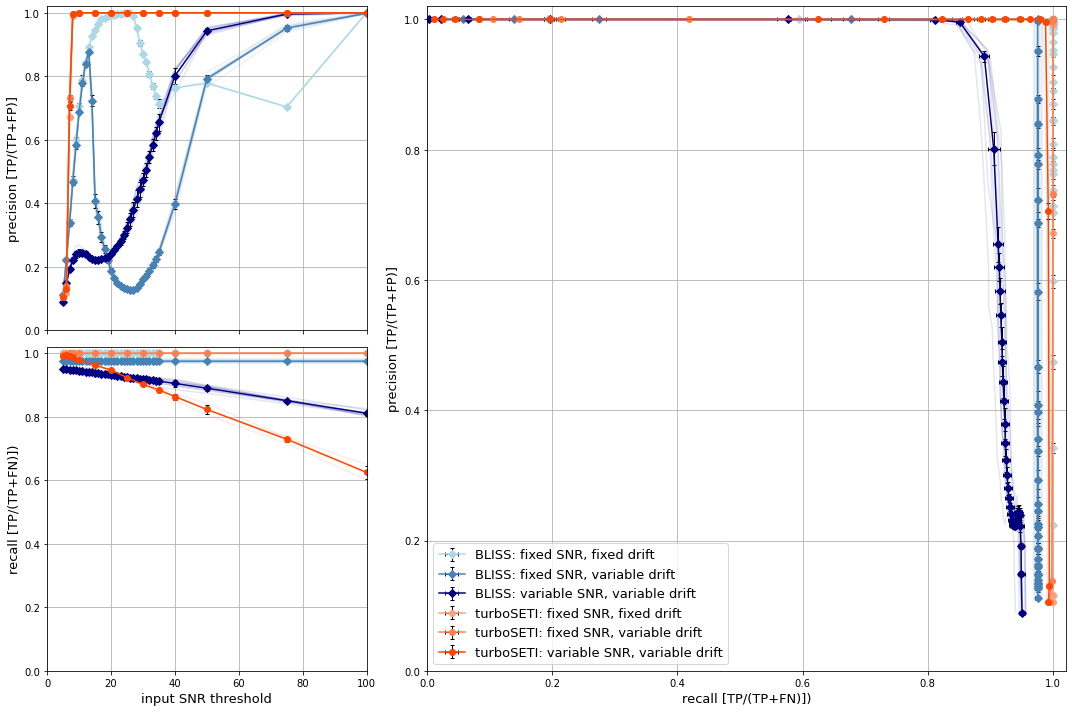

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,10), gridspec_kw={'width_ratios': [1, 2]}, sharex=True)
gs = axs[0,1].get_gridspec()
# remove the underlying Axes
for ax in axs[:, -1]:
    ax.remove()
axbig = fig.add_subplot(gs[:, -1])

sp_arr = []
sr_arr = []

for n in range(3):
    m = n
    dats = glob.glob(f'/datax/scratch/benjb/bliss_voyager_test/injections/high_SNR_no_drift_injections/synthetic_data_2000_injections_{m}.*.dat')
    #dats = glob.glob(f'/datax/scratch/benjb/bliss_voyager_test/injections/high_SNR_injections/synthetic_data_2000_injections_{m}*.dat')
    print(m)

    snrs = []
    fps = []
    tps = []
    fns = []
    precisions = []
    recalls = []

    a = np.load(f'/datax/scratch/benjb/bliss_voyager_test/injections/high_SNR_no_drift_injections/synthetic_data_2000_injection_parameters_{m}.npy')
    drifts = a[1]

    for k in range(len(dats)):

        dat = dats[k]

        snr = float(dat[118:-4])
        #print(snr)
        snrs.append(snr)

        df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                                    'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                                    'Full_number_of_hits'], skiprows=9)
        ff = df['freq_start'].values
        dd = df['Drift_Rate'].values
        n_inj = 1000
        fillspace = 10000
        pfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + fillspace/1e6 + 10000
        nfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + 3*fillspace/1e6 + 10000
        #print(pfreqs[:10])
        #print(nfreqs[:10])

        fp = 0
        tp = 0
        tn = 0
        fn = 0

        for i in range(n_inj):
            pf = pfreqs[i]
            nf = nfreqs[i]
            pdiffvec = ff - pf
            ndiffvec = ff - nf

            d = drifts[2*i]

            if len(pdiffvec) == 0:
                fn += 1
                tn += 1 # TN not a good metric, not used
                continue
            best_candidate_idxs = np.where(np.abs(pdiffvec)*1000 < 2)[0]
            best_candidate_drifts = np.concatenate((dd[best_candidate_idxs], [1])) # add 1 as a fix for len-0 case
            if (np.min(np.abs(pdiffvec))*1000 < 2) & (np.min(np.abs(best_candidate_drifts-d)) < 0.5): # permit accuracy to within 2 kHz
                tp += 1
            else:
                fn += 1
            if np.min(np.abs(ndiffvec))*1000 > 10: # whole block must be clear
                tn += 1
        fp = len(ff)-tp

        #print(f'TP: {tp}')
        #print(f'FP: {fp}')
        #print(f'FN: {fn}')

        #print(f'precision: {tp/(tp+fp)}')
        #print(f'recall: {tp/(tp+fn)}')
        if (tp+fp) > 0:
            precisions.append(tp/(tp+fp))
        else:
            precisions.append(1)
        recalls.append(tp/(tp+fn))
    
    snrs = np.array(snrs)
    precisions = np.array(precisions)
    recalls = np.array(recalls)

    sp = precisions[np.argsort(snrs)]
    sr = recalls[np.argsort(snrs)]
    sp_arr.append(sp)
    sr_arr.append(sr)
    axs[0,0].plot(np.sort(snrs), sp, color='lightblue', alpha=0.1)
    axs[1,0].plot(np.sort(snrs), sr, color='lightblue', alpha=0.1)
    axbig.plot(sr, sp, color='lightblue', alpha=0.1)

sp_arr = np.transpose(sp_arr)
sr_arr = np.transpose(sr_arr)
print(np.shape(sp_arr))

sp_avgvec = [] # y-positions of points for average PR curve
sr_avgvec = [] # x-positions '''
sp_errvec = [] # y-errors '''
sr_errvec = [] # x-errors '''
distvec = [] # distances of points from (1, 1)

for i in range(len(sp_arr)):

    sp_bit = sp_arr[i]
    sr_bit = sr_arr[i]
    
    sp_avg = np.mean(sp_bit)
    sr_avg = np.mean(sr_bit)
    sp_err = np.std(sp_bit)
    sr_err = np.std(sr_bit)

    sp_avgvec.append(sp_avg)
    sr_avgvec.append(sr_avg)
    sp_errvec.append(sp_err)
    sr_errvec.append(sr_err)

    distance = np.sqrt((1-sp_avg)**2 + (1-sr_avg)**2)
    distvec.append(distance)

axs[0,0].errorbar(x=np.sort(snrs), y=sp_avgvec, yerr=sp_errvec, marker='D', color='lightblue',
             ecolor='k', capsize=2, elinewidth=1)
axs[1,0].errorbar(x=np.sort(snrs), y=sr_avgvec, yerr=sr_errvec, marker='D', color='lightblue',
             ecolor='k', capsize=2, elinewidth=1)
axbig.errorbar(x=sr_avgvec, y=sp_avgvec, yerr=sp_errvec, xerr=sr_errvec, marker='D', color='lightblue',
             ecolor='k', capsize=2, elinewidth=1, label='BLISS: fixed SNR, fixed drift')


sp_arr = []
sr_arr = []

for n in range(10):
    m = n
    #dats = glob.glob(f'/datax/scratch/benjb/bliss_voyager_test/injections/high_SNR_no_drift_injections/synthetic_data_2000_injections_{m}*.dat')
    dats = glob.glob(f'/datax/scratch/benjb/bliss_voyager_test/injections/high_SNR_injections/synthetic_data_2000_injections_{m}*.dat')
    print(m)

    snrs = []
    fps = []
    tps = []
    fns = []
    precisions = []
    recalls = []

    a = np.load(f'/datax/scratch/benjb/bliss_voyager_test/injections/high_SNR_injections/synthetic_data_2000_injection_parameters_{m}.npy')
    drifts = a[1]
    if m == 0:
        print(drifts)

    for k in range(len(dats)):

        dat = dats[k]

        snr = float(dat[109:-4])
        #print(snr)
        snrs.append(snr)

        df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                                    'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                                    'Full_number_of_hits'], skiprows=9)
        ff = df['freq_start'].values
        dd = df['Drift_Rate'].values
        n_inj = 1000
        fillspace = 10000
        pfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + fillspace/1e6 + 10000
        nfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + 3*fillspace/1e6 + 10000
        #print(pfreqs[:10])
        #print(nfreqs[:10])

        fp = 0
        tp = 0
        tn = 0
        fn = 0

        for i in range(n_inj):
            pf = pfreqs[i]
            nf = nfreqs[i]
            pdiffvec = ff - pf
            ndiffvec = ff - nf

            d = drifts[2*i]

            best_candidate_idxs = np.where(np.abs(pdiffvec)*1000 < 2)[0]
            best_candidate_drifts = np.concatenate((dd[best_candidate_idxs], [1])) # add 1 as a fix for len-0 case
            if (np.min(np.abs(pdiffvec))*1000 < 2) & (np.min(np.abs(best_candidate_drifts-d)) < 0.5): # permit accuracy to within 2 kHz
                tp += 1
            else:
                fn += 1
            if np.min(np.abs(ndiffvec))*1000 > 10: # whole block must be clear
                tn += 1
        fp = len(ff)-tp

        #print(f'TP: {tp}')
        #print(f'FP: {fp}')
        #print(f'FN: {fn}')

        #print(f'precision: {tp/(tp+fp)}')
        #print(f'recall: {tp/(tp+fn)}')
        precisions.append(tp/(tp+fp))
        recalls.append(tp/(tp+fn))
    
    snrs = np.array(snrs)
    precisions = np.array(precisions)
    recalls = np.array(recalls)

    sp = precisions[np.argsort(snrs)]
    sr = recalls[np.argsort(snrs)]
    sp_arr.append(sp)
    sr_arr.append(sr)
    axs[0,0].plot(np.sort(snrs), sp, color='steelblue', alpha=0.1)
    axs[1,0].plot(np.sort(snrs), sr, color='steelblue', alpha=0.1)
    axbig.plot(sr, sp, color='steelblue', alpha=0.1)

sp_arr = np.transpose(sp_arr)
sr_arr = np.transpose(sr_arr)
print(np.shape(sp_arr))

sp_avgvec = [] # y-positions of points for average PR curve
sr_avgvec = [] # x-positions '''
sp_errvec = [] # y-errors '''
sr_errvec = [] # x-errors '''
distvec = [] # distances of points from (1, 1)

for i in range(len(sp_arr)):

    sp_bit = sp_arr[i]
    sr_bit = sr_arr[i]
    
    sp_avg = np.mean(sp_bit)
    sr_avg = np.mean(sr_bit)
    sp_err = np.std(sp_bit)
    sr_err = np.std(sr_bit)

    sp_avgvec.append(sp_avg)
    sr_avgvec.append(sr_avg)
    sp_errvec.append(sp_err)
    sr_errvec.append(sr_err)

    distance = np.sqrt((1-sp_avg)**2 + (1-sr_avg)**2)
    distvec.append(distance)

axs[0,0].errorbar(x=np.sort(snrs), y=sp_avgvec, yerr=sp_errvec, marker='D', color='steelblue',
             ecolor='k', capsize=2, elinewidth=1)
axs[1,0].errorbar(x=np.sort(snrs), y=sr_avgvec, yerr=sr_errvec, marker='D', color='steelblue',
             ecolor='k', capsize=2, elinewidth=1)
axbig.errorbar(x=sr_avgvec, y=sp_avgvec, yerr=sp_errvec, xerr=sr_errvec, marker='D', color='steelblue',
             ecolor='k', capsize=2, elinewidth=1, label='BLISS: fixed SNR, variable drift')

sp_arr = []
sr_arr = []

for n in range(9):
    m = n+1
    dats = glob.glob(f'/datax/scratch/benjb/bliss_voyager_test/injections/synthetic_data_2000_injections_{m}*.dat')
    print(m)

    snrs = []
    fps = []
    tps = []
    fns = []
    precisions = []
    recalls = []

    a = np.load(f'/datax/scratch/benjb/bliss_voyager_test/injections/synthetic_data_2000_injection_parameters_{m}.npy')
    drifts = a[1]

    for k in range(len(dats)):

        dat = dats[k]

        snr = float(dat[89:-4])
        #print(snr)
        snrs.append(snr)

        df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                                    'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                                    'Full_number_of_hits'], skiprows=9)
        ff = df['freq_start'].values
        dd = df['Drift_Rate'].values
        n_inj = 1000
        fillspace = 10000
        pfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + fillspace/1e6 + 10000
        nfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + 3*fillspace/1e6 + 10000
        #print(pfreqs[:10])
        #print(nfreqs[:10])

        fp = 0
        tp = 0
        tn = 0
        fn = 0

        for i in range(n_inj):
            pf = pfreqs[i]
            nf = nfreqs[i]
            pdiffvec = ff - pf
            ndiffvec = ff - nf
            
            d = drifts[2*i]

            best_candidate_idxs = np.where(np.abs(pdiffvec)*1000 < 2)[0]
            best_candidate_drifts = np.concatenate((dd[best_candidate_idxs], [1])) # add 1 as a fix for len-0 case
            if (np.min(np.abs(pdiffvec))*1000 < 2) & (np.min(np.abs(best_candidate_drifts-d)) < 0.5): # permit accuracy to within 2 kHz
                tp += 1
            else:
                fn += 1
            if np.min(np.abs(ndiffvec))*1000 > 10: # whole block must be clear
                tn += 1
        fp = len(ff)-tp

        if (tp+fp) > 0:
            precisions.append(tp/(tp+fp))
        else:
            precisions.append(1)
        recalls.append(tp/(tp+fn))
    
    snrs = np.array(snrs)
    precisions = np.array(precisions)
    recalls = np.array(recalls)

    sp = precisions[np.argsort(snrs)]
    sr = recalls[np.argsort(snrs)]
    sp_arr.append(sp)
    sr_arr.append(sr)
    axs[0,0].plot(np.sort(snrs), sp, color='navy', alpha=0.1)
    axs[1,0].plot(np.sort(snrs), sr, color='navy', alpha=0.1)
    axbig.plot(sr, sp, color='navy', alpha=0.1)

sp_arr = np.transpose(sp_arr)
sr_arr = np.transpose(sr_arr)
print(np.shape(sp_arr))

sp_avgvec = [] # y-positions of points for average PR curve
sr_avgvec = [] # x-positions '''
sp_errvec = [] # y-errors '''
sr_errvec = [] # x-errors '''
distvec = [] # distances of points from (1, 1)

for i in range(len(sp_arr)):

    sp_bit = sp_arr[i]
    sr_bit = sr_arr[i]
    
    sp_avg = np.mean(sp_bit)
    sr_avg = np.mean(sr_bit)
    sp_err = np.std(sp_bit)
    sr_err = np.std(sr_bit)

    sp_avgvec.append(sp_avg)
    sr_avgvec.append(sr_avg)
    sp_errvec.append(sp_err)
    sr_errvec.append(sr_err)

    distance = np.sqrt((1-sp_avg)**2 + (1-sr_avg)**2)
    distvec.append(distance)

axs[0,0].errorbar(x=np.sort(snrs), y=sp_avgvec, yerr=sp_errvec, marker='D', color='navy',
             ecolor='k', capsize=2, elinewidth=1)
axs[1,0].errorbar(x=np.sort(snrs), y=sr_avgvec, yerr=sr_errvec, marker='D', color='navy',
             ecolor='k', capsize=2, elinewidth=1)
axbig.errorbar(x=sr_avgvec, y=sp_avgvec, yerr=sp_errvec, xerr=sr_errvec, marker='D', color='navy',
             ecolor='k', capsize=2, elinewidth=1, label='BLISS: variable SNR, variable drift')

turboseti_snr_list = [5,6,7,8,10,15,20,25,30,35,40,50,75,100,250,500,750,1000,1250]

sp_arr = []
sr_arr = []

for n in range(3):
    snrs = []
    fps = []
    tps = []
    fns = []
    precisions = []
    recalls = []
    
    for snr in turboseti_snr_list:
        m = n
        dats = glob.glob(f'/datax/scratch/benjb/bliss_voyager_test/injections/high_SNR_no_drift_injections/seticore/{snr}/synthetic_data_2000_injections_{m}*.dat')

        dat = dats[0]

        a = np.load(f'/datax/scratch/benjb/bliss_voyager_test/injections/high_SNR_no_drift_injections/synthetic_data_2000_injection_parameters_{m}.npy')
        drifts = a[1]

        snrs.append(snr)

        df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                                    'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                                    'Full_number_of_hits'], skiprows=9)
        ff = df['Uncorrected_Frequency'].values
        dd = df['Drift_Rate'].values
        n_inj = 1000
        fillspace = 10000
        pfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + fillspace/1e6 + 10000
        nfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + 3*fillspace/1e6 + 10000
        #print(pfreqs[:10])
        #print(nfreqs[:10])

        fp = 0
        tp = 0
        tn = 0
        fn = 0

        for i in range(n_inj):
            pf = pfreqs[i]
            nf = nfreqs[i]
            pdiffvec = ff - pf
            ndiffvec = ff - nf

            d = drifts[2*i]

            if (np.min(np.abs(pdiffvec))*1000 < 2) & (np.abs(dd[np.argmin(np.abs(pdiffvec))]-d) < 0.5): # permit accuracy to within 2 kHz
                tp += 1 # double check this if statement!
            else:
                fn += 1
            if np.min(np.abs(ndiffvec))*1000 > 10: # whole block must be clear
                tn += 1
        fp = len(ff)-tp

        if (tp+fp) > 0:
            precisions.append(tp/(tp+fp))
        else:
            precisions.append(1)
        recalls.append(tp/(tp+fn))
    
    snrs = np.array(snrs)
    precisions = np.array(precisions)
    recalls = np.array(recalls)

    sp = precisions[np.argsort(snrs)]
    sr = recalls[np.argsort(snrs)]
    sp_arr.append(sp)
    sr_arr.append(sr)
    axs[0,0].plot(np.sort(snrs), sp, color='lightsalmon', alpha=0.1)
    axs[1,0].plot(np.sort(snrs), sr, color='lightsalmon', alpha=0.1)
    axbig.plot(sr, sp, color='lightsalmon', alpha=0.1)

sp_arr = np.transpose(sp_arr)
sr_arr = np.transpose(sr_arr)
print(np.shape(sp_arr))

sp_avgvec = [] # y-positions of points for average PR curve
sr_avgvec = [] # x-positions '''
sp_errvec = [] # y-errors '''
sr_errvec = [] # x-errors '''
distvec = [] # distances of points from (1, 1)

for i in range(len(sp_arr)):

    sp_bit = sp_arr[i]
    sr_bit = sr_arr[i]
    
    sp_avg = np.mean(sp_bit)
    sr_avg = np.mean(sr_bit)
    sp_err = np.std(sp_bit)
    sr_err = np.std(sr_bit)

    sp_avgvec.append(sp_avg)
    sr_avgvec.append(sr_avg)
    sp_errvec.append(sp_err)
    sr_errvec.append(sr_err)

    distance = np.sqrt((1-sp_avg)**2 + (1-sr_avg)**2)
    distvec.append(distance)

axs[0,0].errorbar(x=np.sort(snrs), y=sp_avgvec, yerr=sp_errvec, marker='o', color='lightsalmon',
             ecolor='k', capsize=2, elinewidth=1)
axs[1,0].errorbar(x=np.sort(snrs), y=sr_avgvec, yerr=sr_errvec, marker='o', color='lightsalmon',
             ecolor='k', capsize=2, elinewidth=1)
axbig.errorbar(x=sr_avgvec, y=sp_avgvec, yerr=sp_errvec, xerr=sr_errvec, marker='o', color='lightsalmon',
             ecolor='k', capsize=2, elinewidth=1, label='turboSETI: fixed SNR, fixed drift')

sp_arr = []
sr_arr = []

for n in range(3):
    snrs = []
    fps = []
    tps = []
    fns = []
    precisions = []
    recalls = []
    
    for snr in turboseti_snr_list:
        m = n
        dats = glob.glob(f'/datax/scratch/benjb/bliss_voyager_test/injections/high_SNR_injections/seticore/{snr}/synthetic_data_2000_injections_{m}*.dat')

        dat = dats[0]

        a = np.load(f'/datax/scratch/benjb/bliss_voyager_test/injections/high_SNR_injections/synthetic_data_2000_injection_parameters_{m}.npy')
        drifts = a[1]

        snrs.append(snr)

        df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                                    'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                                    'Full_number_of_hits'], skiprows=9)
        ff = df['Uncorrected_Frequency'].values
        dd = df['Drift_Rate'].values
        n_inj = 1000
        fillspace = 10000
        pfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + fillspace/1e6 + 10000
        nfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + 3*fillspace/1e6 + 10000
        #print(pfreqs[:10])
        #print(nfreqs[:10])

        fp = 0
        tp = 0
        tn = 0
        fn = 0

        for i in range(n_inj):
            pf = pfreqs[i]
            nf = nfreqs[i]
            pdiffvec = ff - pf
            ndiffvec = ff - nf

            d = drifts[2*i]

            if (np.min(np.abs(pdiffvec))*1000 < 2) & (np.abs(dd[np.argmin(np.abs(pdiffvec))]-d) < 0.5): # permit accuracy to within 2 kHz
                tp += 1 # double check this if statement!
            else:
                fn += 1
            if np.min(np.abs(ndiffvec))*1000 > 10: # whole block must be clear
                tn += 1
        fp = len(ff)-tp

        if (tp+fp) > 0:
            precisions.append(tp/(tp+fp))
        else:
            precisions.append(1)
        recalls.append(tp/(tp+fn))
    
    snrs = np.array(snrs)
    precisions = np.array(precisions)
    recalls = np.array(recalls)

    sp = precisions[np.argsort(snrs)]
    sr = recalls[np.argsort(snrs)]
    sp_arr.append(sp)
    sr_arr.append(sr)
    axs[0,0].plot(np.sort(snrs), sp, color='coral', alpha=0.1)
    axs[1,0].plot(np.sort(snrs), sr, color='coral', alpha=0.1)
    axbig.plot(sr, sp, color='coral', alpha=0.1)

sp_arr = np.transpose(sp_arr)
sr_arr = np.transpose(sr_arr)
print(np.shape(sp_arr))

sp_avgvec = [] # y-positions of points for average PR curve
sr_avgvec = [] # x-positions '''
sp_errvec = [] # y-errors '''
sr_errvec = [] # x-errors '''
distvec = [] # distances of points from (1, 1)

for i in range(len(sp_arr)):

    sp_bit = sp_arr[i]
    sr_bit = sr_arr[i]
    
    sp_avg = np.mean(sp_bit)
    sr_avg = np.mean(sr_bit)
    sp_err = np.std(sp_bit)
    sr_err = np.std(sr_bit)

    sp_avgvec.append(sp_avg)
    sr_avgvec.append(sr_avg)
    sp_errvec.append(sp_err)
    sr_errvec.append(sr_err)

    distance = np.sqrt((1-sp_avg)**2 + (1-sr_avg)**2)
    distvec.append(distance)

axs[0,0].errorbar(x=np.sort(snrs), y=sp_avgvec, yerr=sp_errvec, marker='o', color='coral',
             ecolor='k', capsize=2, elinewidth=1)
axs[1,0].errorbar(x=np.sort(snrs), y=sr_avgvec, yerr=sr_errvec, marker='o', color='coral',
             ecolor='k', capsize=2, elinewidth=1)
axbig.errorbar(x=sr_avgvec, y=sp_avgvec, yerr=sp_errvec, xerr=sr_errvec, marker='o', color='coral',
             ecolor='k', capsize=2, elinewidth=1, label='turboSETI: fixed SNR, variable drift')

sp_arr = []
sr_arr = []

for n in range(3):
    snrs = []
    fps = []
    tps = []
    fns = []
    precisions = []
    recalls = []
    
    for snr in turboseti_snr_list:
        m = n+1
        dats = glob.glob(f'/datax/scratch/benjb/bliss_voyager_test/injections/seticore/{snr}/synthetic_data_2000_injections_{m}*.dat')

        dat = dats[0]

        snrs.append(snr)

        a = np.load(f'/datax/scratch/benjb/bliss_voyager_test/injections/synthetic_data_2000_injection_parameters_{m}.npy')
        drifts = a[1]

        df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                                    'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                                    'Full_number_of_hits'], skiprows=9)
        ff = df['Uncorrected_Frequency'].values
        dd = df['Drift_Rate'].values
        n_inj = 1000
        fillspace = 10000
        pfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + fillspace/1e6 + 10000
        nfreqs = np.arange(n_inj)*(4*fillspace)/1e6 + 3*fillspace/1e6 + 10000
        #print(pfreqs[:10])
        #print(nfreqs[:10])

        print('len pfreqs = ', len(pfreqs))
        print('len drifts = ', len(drifts))

        fp = 0
        tp = 0
        tn = 0
        fn = 0

        for i in range(n_inj):
            pf = pfreqs[i]
            nf = nfreqs[i]
            pdiffvec = ff - pf
            ndiffvec = ff - nf

            d = drifts[2*i]

            if (np.min(np.abs(pdiffvec))*1000 < 2) & (np.abs(dd[np.argmin(np.abs(pdiffvec))]-d) < 0.5): # permit accuracy to within 2 kHz
                tp += 1 # double check this if statement!
            else:
                fn += 1
            if np.min(np.abs(ndiffvec))*1000 > 10: # whole block must be clear
                tn += 1
        fp = len(ff)-tp

        if (tp+fp) > 0:
            precisions.append(tp/(tp+fp))
        else:
            precisions.append(1)
        recalls.append(tp/(tp+fn))
    
    snrs = np.array(snrs)
    precisions = np.array(precisions)
    recalls = np.array(recalls)

    sp = precisions[np.argsort(snrs)]
    sr = recalls[np.argsort(snrs)]
    sp_arr.append(sp)
    sr_arr.append(sr)
    axs[0,0].plot(np.sort(snrs), sp, color='orangered', alpha=0.1)
    axs[1,0].plot(np.sort(snrs), sr, color='orangered', alpha=0.1)
    axbig.plot(sr, sp, color='orangered', alpha=0.1)

sp_arr = np.transpose(sp_arr)
sr_arr = np.transpose(sr_arr)
print(np.shape(sp_arr))

sp_avgvec = [] # y-positions of points for average PR curve
sr_avgvec = [] # x-positions '''
sp_errvec = [] # y-errors '''
sr_errvec = [] # x-errors '''
distvec = [] # distances of points from (1, 1)

for i in range(len(sp_arr)):

    sp_bit = sp_arr[i]
    sr_bit = sr_arr[i]
    
    sp_avg = np.mean(sp_bit)
    sr_avg = np.mean(sr_bit)
    sp_err = np.std(sp_bit)
    sr_err = np.std(sr_bit)

    sp_avgvec.append(sp_avg)
    sr_avgvec.append(sr_avg)
    sp_errvec.append(sp_err)
    sr_errvec.append(sr_err)

    distance = np.sqrt((1-sp_avg)**2 + (1-sr_avg)**2)
    distvec.append(distance)

axs[0,0].errorbar(x=np.sort(snrs), y=sp_avgvec, yerr=sp_errvec, marker='o', color='orangered',
             ecolor='k', capsize=2, elinewidth=1)
axs[1,0].errorbar(x=np.sort(snrs), y=sr_avgvec, yerr=sr_errvec, marker='o', color='orangered',
             ecolor='k', capsize=2, elinewidth=1)
axbig.errorbar(x=sr_avgvec, y=sp_avgvec, yerr=sp_errvec, xerr=sr_errvec, marker='o', color='orangered',
             ecolor='k', capsize=2, elinewidth=1, label='turboSETI: variable SNR, variable drift')




axbig.set_xlabel('recall [TP/(TP+FN)])', size=13)
axbig.set_ylabel('precision [TP/(TP+FP)]', size=13)

#axs[0,0].set_xlabel('input SNR threshold', size=13)
axs[0,0].set_ylabel('precision [TP/(TP+FP)]', size=13)

axs[1,0].set_xlabel('input SNR threshold', size=13)
axs[1,0].set_ylabel('recall [TP/(TP+FN)])', size=13)

axbig.legend(loc='lower left', fontsize=13)
axbig.grid(which='major')

axs[0,0].set_xlim(0,100)
axs[0,0].set_ylim(0,1.02)
axs[0,0].grid(which='major')

axs[1,0].set_xlim(0,100)
axs[1,0].set_ylim(0,1.02)
axs[1,0].grid(which='major')

axbig.set_xlim(0,1.02)
axbig.set_ylim(0,1.02)

fig.tight_layout()

plt.savefig('/datax/scratch/benjb/bliss_voyager_test/injections/bliss_turboSETI_PR_curves_full.pdf', bbox_inches='tight')

plt.show()

In [2]:
import numpy as np
a = np.load('/datax/scratch/benjb/bliss_voyager_test/injections/high_SNR_injections/synthetic_data_2000_injection_parameters_0.npy')
print(a[0])
print(a[1])
print(a[2])
print(len(a[2]))

[10000.01 10000.03 10000.05 ... 10039.95 10039.97 10039.99]
[ 2.1225392   1.29978325  1.65274617 ... -3.38556048  2.46421917
 -3.17518549]
[1000. 1000. 1000. ... 1000. 1000. 1000.]
2000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


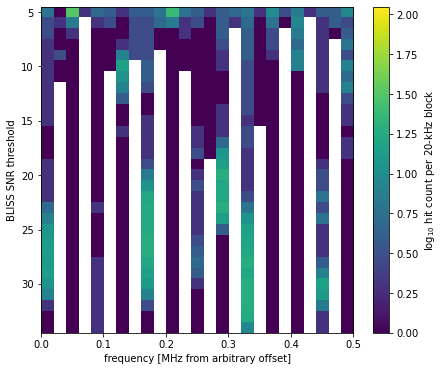

In [50]:
hist_arr = []
fig, ax = plt.subplots(figsize=(7,6))
for j in np.arange(start=5, stop=35):
    dats = glob.glob(f'/datax/scratch/benjb/bliss_voyager_test/injections/synthetic_data_2000_injections_*.0000_{j}.dat')
    for i in range(len(dats)):
        fvec = []
        dat = dats[i]
        df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                                'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                                'Full_number_of_hits'], skiprows=9)
        ff = df['freq_start'].values
        fvec.append(ff)
    fvec = np.concatenate(fvec)
    hist,_ = np.histogram(ff, bins=2000, range=(10000, 10040))
    hist_arr.append(hist)
#hist_arr.append(np.zeros_like(hist_arr[0])+1000)
hist_arr = np.array(hist_arr)
plt.imshow(np.log10(hist_arr), aspect='auto', 
           #cmap='binary', 
           interpolation='None', extent=(0, 40, 34.5, 4.5))
plt.xlabel('frequency [MHz from arbitrary offset]')
plt.ylabel('BLISS SNR threshold')
plt.colorbar(label=r'log$_{10}$ hit count per 20-kHz block')
plt.xlim(0, 0.5)
plt.show()


In [19]:
print(np.min(ff))
print(np.max(ff))

10000.000039
10039.998392
